In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.utils import resample

import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import os

In [68]:
# Citation:
# @misc{make ml,
#   title={Road Signs Dataset},
#   url={https://makeml.app/datasets/road-signs},
#   journal={Make ML}
# }

In [2]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

def load_images_and_labels(annotation_folder, image_folder, target_size=(64, 64)):
    images = []
    labels = []

    # Define the class names and map them to integer values
    class_mapping = {"trafficlight": 0, "stop": 1, "speedlimit": 2, "crosswalk": 3}

    # Sort filenames numerically for consistency
    xml_files = sorted(
        [f for f in os.listdir(annotation_folder) if f.endswith(".xml")],
        key=lambda x: int(x.split("road")[-1].split(".")[0])
    )

    for xml_file in xml_files:
        # Parse XML
        tree = ET.parse(os.path.join(annotation_folder, xml_file))
        root = tree.getroot()
        filename = root.find("filename").text
        image_path = os.path.join(image_folder, filename)

        # Load and resize image
        img = read_image(image_path)

        for obj in root.findall("object"):
            label = obj.find("name").text
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)

            # Convert the label to its corresponding integer
            if label in class_mapping:
                label_int = class_mapping[label]
            else:
                raise ValueError(f"Label {label} is not in the predefined class list.")

            cropped_img = img[ymin:ymax, xmin:xmax]

            cropped_img_resized = cv2.resize(cropped_img, target_size)
            
            # Append masked image and corresponding label
            images.append(cropped_img_resized)
            labels.append({"label": label_int, "xmin": xmin, "ymin": ymin, "xmax": xmax, "ymax": ymax})

    return np.array(images), labels

In [23]:
def oversample(X, y):
    # Separate classes
    classes = np.unique(y)
    max_class_size = max([np.sum(y == cls) for cls in classes])  # Get the maximum class size
    
    X_resampled = []
    y_resampled = []
    
    for cls in classes:
        # Select all instances of the current class
        X_class = X[y == cls]
        y_class = y[y == cls]
        
        # Resample: either by random duplication
        X_resampled_class, y_resampled_class = resample(X_class, y_class, replace=True, n_samples=max_class_size, random_state=42)
        
        # Add resampled data to the final dataset
        X_resampled.append(X_resampled_class)
        y_resampled.append(y_resampled_class)
    
    # Stack them back into numpy arrays
    X_resampled = np.vstack(X_resampled)
    y_resampled = np.hstack(y_resampled)
    
    return X_resampled, y_resampled

def undersample(X, y):
    # Separate classes
    classes = np.unique(y)
    min_class_size = min([np.sum(y == cls) for cls in classes])  # Get the minimum class size
    
    X_resampled = []
    y_resampled = []
    
    for cls in classes:
        # Select all instances of the current class
        X_class = X[y == cls]
        y_class = y[y == cls]
        
        # Resample: random undersampling
        X_resampled_class, y_resampled_class = resample(X_class, y_class, replace=False, n_samples=min_class_size, random_state=42)
        
        # Add undersampled data to the final dataset
        X_resampled.append(X_resampled_class)
        y_resampled.append(y_resampled_class)
    
    # Stack them back into numpy arrays
    X_resampled = np.vstack(X_resampled)
    y_resampled = np.hstack(y_resampled)
    
    return X_resampled, y_resampled

def prepare_dataset(annotation_folder, image_folder, test_size=0.2, resample_method="none"):
    # Load data
    images, labels = load_images_and_labels(annotation_folder, image_folder)
    
    # Convert labels to a simple array format (just the integer labels)
    y = np.array([label["label"] for label in labels])
    
    # Use stratified shuffle split to ensure balanced class distribution
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    for train_index, test_index in sss.split(images, y):
        X_train, X_test = images[train_index], images[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
    if resample_method == "oversample":
        # Apply oversampling to the training set
        X_train, y_train = oversample(X_train, y_train)
    
    elif resample_method == "undersample":
        # Apply undersampling to the training set
        X_train, y_train = undersample(X_train, y_train)
    
    return (X_train, y_train), (X_test, y_test)

# Example usage
annotation_folder = "dataset/annotations"
image_folder = "dataset/images"

# Prepare the dataset with oversampling (or undersampling or no resampling)
(X_train, y_train), (X_test, y_test) = prepare_dataset(annotation_folder, image_folder, resample_method="oversample")

# Split the training set into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print the shapes of the datasets
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_val.shape:", X_val.shape)
print("y_val.shape:", y_val.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (2003, 64, 64, 3)
y_train.shape: (2003,)
X_val.shape: (501, 64, 64, 3)
y_val.shape: (501,)
X_test.shape: (249, 64, 64, 3)
y_test.shape: (249,)


In [12]:
y_train = y_train.reshape(-1)
y_val = y_val.reshape(-1)
y_test = y_test.reshape(-1)
y_train[:5]

array([3, 0, 3, 3, 3])

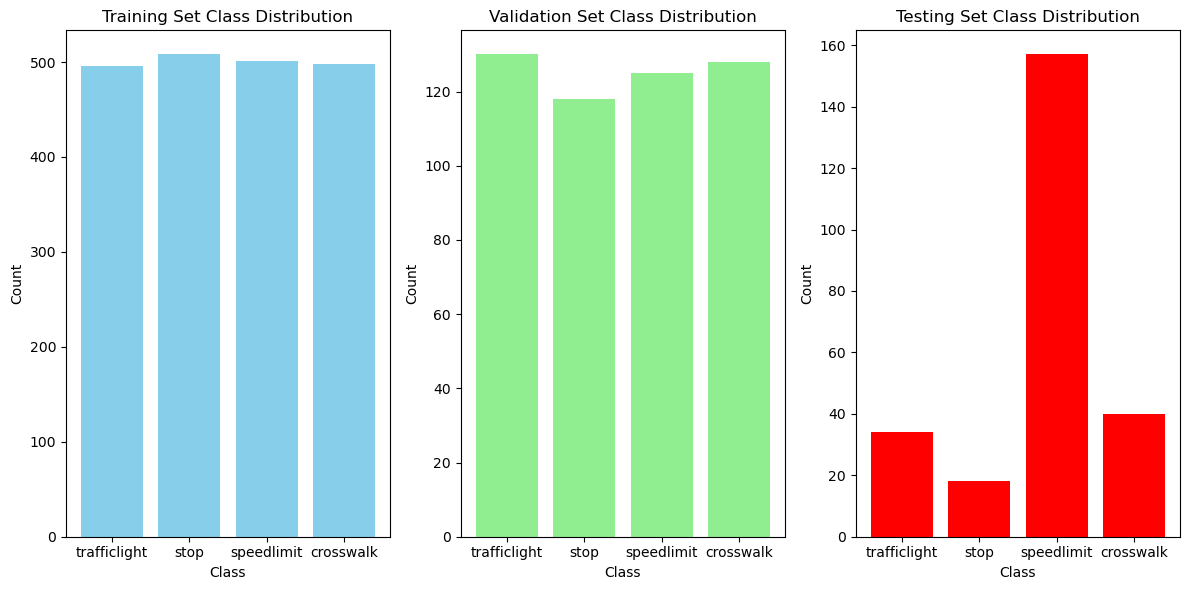

In [14]:
# Count the occurrences of each class in the training and validation datasets
train_class_counts = np.bincount(y_train)
val_class_counts = np.bincount(y_val)
test_class_counts = np.bincount(y_test)

# Define the class names (if available)
classes = ["trafficlight", "stop", "speedlimit", "crosswalk"]

# Plot the distribution of classes in the training and validation sets
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

# Training set class distribution
ax[0].bar(classes, train_class_counts, color='skyblue')
ax[0].set_title('Training Set Class Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')

# Validation set class distribution
ax[1].bar(classes, val_class_counts, color='lightgreen')
ax[1].set_title('Validation Set Class Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Count')

ax[2].bar(classes, test_class_counts, color='red')
ax[2].set_title('Testing Set Class Distribution')
ax[2].set_xlabel('Class')
ax[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [16]:
classes = ["trafficlight", "stop", "speedlimit", "crosswalk"]

def plot_sample(X, y, index):
    plt.figure(figsize = (15,2))
    plt.imshow(X[index])
    plt.xlabel(classes[y[index]])

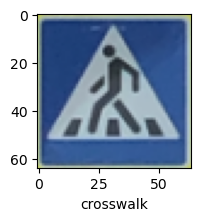

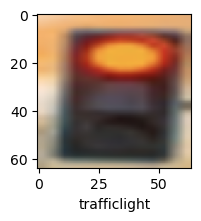

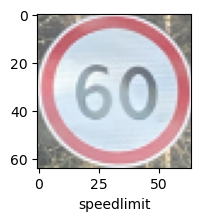

In [18]:
plot_sample(X_train, y_train, 11)
plot_sample(X_val, y_val, 11)
plot_sample(X_test, y_test, 11)

In [28]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [22]:
# Define the parameter grid
learning_rates = [0.001, 0.0001]
batch_sizes = [16, 32, 64]
epochs_list = [50, 100]

# To store the best configuration
best_accuracy = 0
best_params = {}
best_model = None

# Loop through the parameter grid
for lr in learning_rates:
    for batch_size in batch_sizes:
        for epochs in epochs_list:
            print(f"Testing: learning_rate={lr}, batch_size={batch_size}, epochs={epochs}")

            # Define the model
            cnn = models.Sequential([
                layers.Input(shape=(64, 64, 3)),
                layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding='same', 
                              kernel_regularizer=regularizers.l2(0.01)),
                layers.MaxPooling2D((2, 2)),
                
                layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding='same', 
                              kernel_regularizer=regularizers.l2(0.01)),
                layers.MaxPooling2D((2, 2)),
                
                layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', 
                              kernel_regularizer=regularizers.l2(0.01)),
                layers.MaxPooling2D((2, 2)),
                
                layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', 
                              kernel_regularizer=regularizers.l2(0.01)),
                layers.MaxPooling2D((2, 2)),
                
                layers.GlobalAveragePooling2D(),  # Using global average pooling instead of flatten
                layers.Dense(256, activation='relu'),
                layers.Dropout(0.5),
                layers.Dense(4, activation='softmax')
            ])

            
            # Compile the model
            optimizer = Adam(learning_rate=lr)
            cnn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
            
            # Use EarlyStopping to stop if no improvement
            early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

            # Train the model
            history = cnn.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                callbacks=[early_stopping]
            )
            
            # Get the best validation accuracy
            val_accuracy = max(history.history['val_accuracy'])
            print(f"Validation Accuracy: {val_accuracy}")
            
            # Save the best model and parameters
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_params = {
                    "learning_rate": lr,
                    "batch_size": batch_size,
                    "epochs": epochs
                }
                best_model = cnn

print("\nBest Configuration:")
print(f"Learning Rate: {best_params['learning_rate']}")
print(f"Batch Size: {best_params['batch_size']}")
print(f"Epochs: {best_params['epochs']}")
print(f"Best Validation Accuracy: {best_accuracy}")


Testing: learning_rate=0.1, batch_size=16, epochs=50
Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.2456 - loss: 293.9365 - val_accuracy: 0.2495 - val_loss: 59.6918
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.2499 - loss: 53.6638 - val_accuracy: 0.2355 - val_loss: 39.6892
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.2358 - loss: 36.5479 - val_accuracy: 0.2555 - val_loss: 28.6694
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.2327 - loss: 26.7097 - val_accuracy: 0.2595 - val_loss: 21.6001
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.2471 - loss: 20.2502 - val_accuracy: 0.2495 - val_loss: 16.6712
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.2135 - loss: 15.7062 - val_accuracy: 0.2555 - val_loss: 13.1001
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.2362 - loss: 12.3954 - val_accuracy: 0.2555 - val_loss: 10.4669
Epoch 8/50
126/126 ━━━━━━━━━━

In [40]:
test_loss, test_accuracy = cnn.evaluate(X_test, y_test, verbose=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9092 - loss: 0.7761


In [54]:
y_pred = cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [72]:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91        34
           1       0.89      0.94      0.92        18
           2       0.95      0.94      0.95       157
           3       0.86      0.90      0.88        40

    accuracy                           0.93       249
   macro avg       0.91      0.92      0.91       249
weighted avg       0.93      0.93      0.93       249



In [70]:
cm = confusion_matrix(y_test_classes, y_pred_classes)

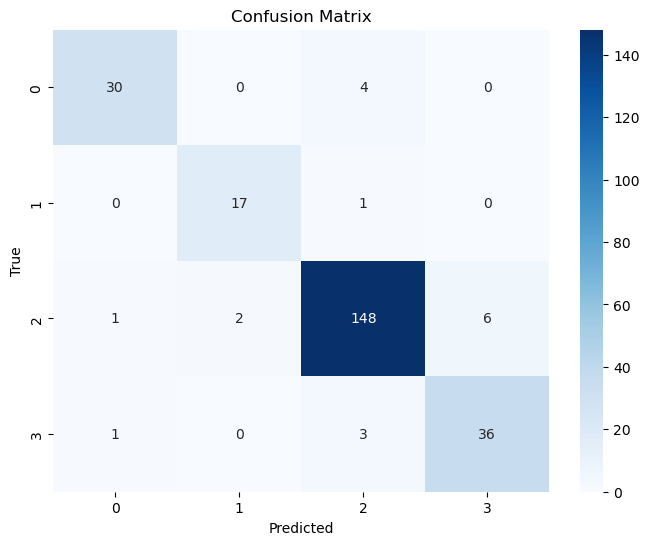

In [64]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test_classes), yticklabels=np.unique(y_test_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()